In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# FederatedCustomerPath

> Learning to predict customer journey with a federated setup

***input***: data + tff conversion function from CustomClientData

***output***: TFF model for predicting customer paths 

***description:***

Simulating federated learning on predicting customer paths.

## Import relevant modules

In [ ]:
#
# uncomment this cell to get the newest version of tff

# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
import numpy as np

import nest_asyncio

nest_asyncio.apply()

You can also view the results using tensorboard:

In [ ]:
%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

train_test_client_split = tff.simulation.datasets.ClientData.train_test_client_split

tff.federated_computation(lambda: "Hello, World!")()

b'Hello, World!'

In [ ]:
import matplotlib.pyplot as plt
from pyarrow import feather
import pandas as pd

In [ ]:
from ml_federated_customer_path.customclientdata import create_tff_client_data_from_df

## Define notebook parameters

Remember, only simple assignments here!

In [ ]:
# this cell is tagged with 'parameters'
seed = 0
data_filepath = "data/preprocessed_data/data.f"
test_split = 0.2

NUM_CLIENTS = 10
NUM_EPOCHS = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 100
FEDERATED_UPDATES = 50

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Data

In [ ]:
df = feather.read_feather(data_filepath)
df

,client_id,x,y
0,0,"[0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",3
1,0,"[1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
2,0,"[2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10
3,1,"[0, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",3
4,1,"[1, 1, 1, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
...,...,...,...
4295,999,"[0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",5
4296,999,"[1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
4297,999,"[2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2
4298,999,"[3, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",6


In [ ]:
df.shape

(4300, 3)

In [ ]:
df.x[0].shape

(16,)

Convert into tff ClientData (training + testing datasets):

In [ ]:
client_data = create_tff_client_data_from_df(df, sample_size=1)
train_data, test_data = train_test_client_split(
    client_data, int(df.client_id.nunique() * test_split)
)

In [ ]:
len(train_data.client_ids)

450

In [ ]:
len(test_data.client_ids)

200

In [ ]:
train_data.element_type_structure

OrderedDict([('x', TensorSpec(shape=(None, 16), dtype=tf.int64, name=None)),
             ('y', TensorSpec(shape=(None,), dtype=tf.int32, name=None))])

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(train_data.client_ids[0])

example_element = next(iter(example_dataset))

example_dataset.element_spec
example_element["x"].numpy()

array([[1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [2, 1, 1, 1, 2, 0, 1, 0,

## Create Federeted ML Process with TFF


In [ ]:
# input layer
def create_keras_model():
    """
    Return new keras model instance
    """
    visible = tf.keras.layers.Input(shape=(16,))

    hidden1 = tf.keras.layers.Dense(32, activation=None, name="l1relu")(visible)
    output = tf.keras.layers.Dense(11, activation="softmax", name="l3softmax")(hidden1)
    model = tf.keras.Model(inputs=visible, outputs=output)
    return model

In [ ]:
input_size = 16
l1_size = 32
l2_size = 0
l3_size = 11

((input_size + 1) * l1_size + (l1_size + 1) * l2_size + (l2_size + 1) * l3_size)

555

In [ ]:
def model_fn():
    """
    Create tff model (keras model + data format + loss & metrics)
    """
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=collections.OrderedDict(
            x=example_dataset.element_spec["x"],
            y=example_dataset.element_spec["y"],
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

Create federated process:

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.RMSprop(learning_rate=1.0),
)

Initialize:

In [ ]:
state = iterative_process.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Create federated evaluation process (validation):

In [ ]:
# evaluation
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
iterable = train_data.create_tf_dataset_for_client(train_data.client_ids[1])

In [ ]:
d = next(iter(iterable))
d

OrderedDict([('x',
              <tf.Tensor: shape=(32, 16), dtype=int64, numpy=
              array([[4, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                     [1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                     [2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [3, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                     [1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                     [2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [3, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                     [2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                     [3, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
train_data.create_tf_dataset_for_client(train_data.client_ids[0])

<PrefetchDataset shapes: OrderedDict([(x, (None, 16)), (y, (None,))]), types: OrderedDict([(x, tf.int64), (y, tf.int32)])>

In [ ]:
len(train_data.client_ids)

450

Function for loading client data in batches:

In [ ]:
def batch_client_data(client_data, batch_size=BATCH_SIZE):
    batch = [
        client_data.create_tf_dataset_for_client(client_data.client_ids[idx])
        for idx in np.random.choice(
            np.arange(len(client_data.client_ids)), size=BATCH_SIZE
        )
    ]
    return batch

### Federated training & evaluation:

In [ ]:
%%time

state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
test_metrics = evaluation(state.model, batch_client_data(test_data))

print("round  1, metrics={}".format(train_metrics))

metrics_df = pd.DataFrame(
    {
        "federated_update": [0],
        "train_loss": [train_metrics["train"]["loss"]],
        "train_accuracy": [train_metrics["train"]["sparse_categorical_accuracy"]],
        "train_size": [train_metrics["stat"]["num_examples"]],
        "test_loss": [test_metrics["loss"]],
        "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
    }
)  # , 'test_loss': float, 'test_size':int})

for i in range(FEDERATED_UPDATES):
    state, train_metrics = iterative_process.next(state, batch_client_data(train_data))
    test_metrics = evaluation(state.model, batch_client_data(test_data))
    metrics_df = pd.concat(
        (
            metrics_df,
            pd.DataFrame(
                {
                    "federated_update": [i + 1],
                    "train_loss": [train_metrics["train"]["loss"]],
                    "train_accuracy": [
                        train_metrics["train"]["sparse_categorical_accuracy"]
                    ],
                    "train_size": [train_metrics["stat"]["num_examples"]],
                    "test_loss": [test_metrics["loss"]],
                    "test_accuracy": [test_metrics["sparse_categorical_accuracy"]],
                }
            ),
        ),
        axis=0,
    )
    print("federated_update  {}, loss={:.2f}, accuracy={:.2f}".format(i + 1, train_metrics['train']['loss'], train_metrics['train']['sparse_categorical_accuracy']))
metrics_df.set_index("federated_update", drop=True, inplace=True)
metrics_df

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.39360902), ('loss', 1.7645308)])), ('stat', OrderedDict([('num_examples', 2660)]))])
federated_update  1, loss=12.56, accuracy=0.22
federated_update  2, loss=13.18, accuracy=0.18
federated_update  3, loss=13.79, accuracy=0.14
federated_update  4, loss=11.42, accuracy=0.29
federated_update  5, loss=9.70, accuracy=0.39
federated_update  6, loss=9.38, accuracy=0.41
federated_update  7, loss=8.59, accuracy=0.46
federated_update  8, loss=7.23, accuracy=0.54
federated_update  9, loss=8.25, accuracy=0.48
federated_update  10, loss=6.71, accuracy=0.58
federated_update  11, loss=7.07, accuracy=0.56
federated_update  12, loss=5.96, accuracy=0.63
federated_update  13, loss=6.26, accuracy=0.61
federated_update  14, loss=5.61, accuracy=0.65
federated_update  15, loss=6.14, accuracy=0.61
federated_update  16, loss=3.99, ac

,train_loss,train_accuracy,train_size,test_loss,test_accuracy
federated_update,,,,,
0,1.764531,0.393609,2660,11.958591,0.258065
1,12.558547,0.216443,2980,13.898114,0.133858
2,13.183716,0.177055,2920,13.762375,0.146154
3,13.789823,0.144245,2780,11.722547,0.272727
4,11.417005,0.291667,2880,10.448619,0.340278
5,9.699088,0.391722,3020,10.290077,0.361702
6,9.377504,0.413475,2820,11.042046,0.314961
7,8.592098,0.464886,2620,8.065631,0.500000
8,7.228274,0.544737,2660,10.065984,0.359712


## Create baseline (centralized model)

Epoch 1/20
45/45 [==============================] - 2s 39ms/step - loss: 1.9806 - sparse_categorical_accuracy: 0.3275 - val_loss: 1.4246 - val_sparse_categorical_accuracy: 0.6017
Epoch 2/20
45/45 [==============================] - 2s 37ms/step - loss: 1.5861 - sparse_categorical_accuracy: 0.6150 - val_loss: 1.2279 - val_sparse_categorical_accuracy: 0.7267
Epoch 3/20
45/45 [==============================] - 2s 36ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.6459 - val_loss: 1.0024 - val_sparse_categorical_accuracy: 0.6917
Epoch 4/20
45/45 [==============================] - 2s 37ms/step - loss: 1.4950 - sparse_categorical_accuracy: 0.5400 - val_loss: 1.0763 - val_sparse_categorical_accuracy: 0.7883
Epoch 5/20
45/45 [==============================] - 2s 36ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.6290 - val_loss: 0.9135 - val_sparse_categorical_accuracy: 0.7967

<AxesSubplot:>

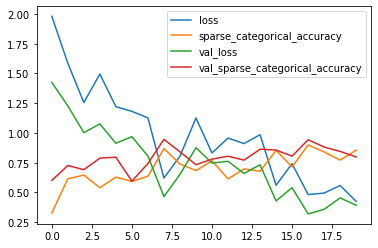

In [ ]:
train_data_centralized = (
    train_data.create_tf_dataset_from_all_clients()
    .map(lambda x: (x["x"][0], x["y"][0]))
    .shuffle(SHUFFLE_BUFFER)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_data_centralized = (
    test_data.create_tf_dataset_from_all_clients()
    .map(lambda x: (x["x"][0], x["y"][0]))
    .shuffle(SHUFFLE_BUFFER)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

centralized_model = create_keras_model()

centralized_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
    optimizer="RMSprop",
)

history = centralized_model.fit(
    train_data_centralized,
    validation_data=test_data_centralized,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
)

pd.DataFrame(history.history).plot()

Plot results:

(0.0, 14.573386797308922)

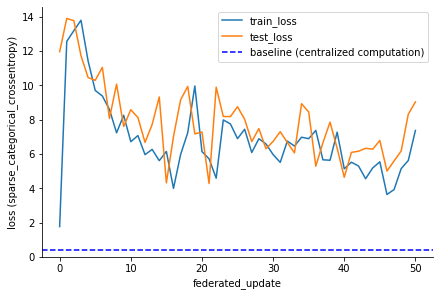

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_loss", "test_loss"])
ax.axhline(
    history.history["val_loss"][-1],
    linestyle="--",
    color="b",
    label="baseline (centralized computation)",
)
ax.set_ylabel("loss (sparse_categorical_crossentropy)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()
ax.set_ylim(ymin=0)

(0.0, 1.0)

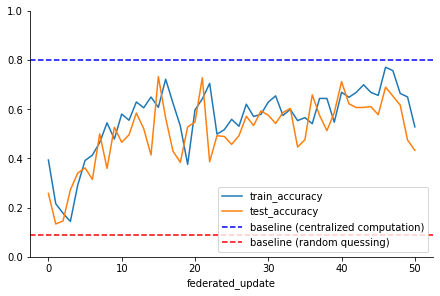

In [ ]:
fig, ax = plt.subplots(1, constrained_layout=True)
metrics_df.plot(ax=ax, y=["train_accuracy", "test_accuracy"])
ax.axhline(
    history.history["val_sparse_categorical_accuracy"][-1],
    linestyle="--",
    color="b",
    label="baseline (centralized computation)",
)
ax.axhline(1 / 11, linestyle="--", color="r", label="baseline (random quessing)")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 1)

## Conclusions

- We can do federated learning of customer paths even with quite little data
- It's not astonishingly good, but neither is our data


- should compare to centralized computation
